In [76]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import os
import numpy as np
np.random.seed(1984)
import tensorflow as tf
tf.set_random_seed(1984)

from scipy import signal
from glob import glob
import re
import pandas as pd
import gc
from scipy.io import wavfile

from keras import optimizers, losses, activations, models
from keras.layers import GRU, Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, Conv3D, ConvLSTM2D
from keras.callbacks import TensorBoard
from keras.models import Sequential
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank

L = 16000
legal_labels = 'yes no up down left right on off stop go silence unknown'.split()

root_path = r'..'
out_path = r'.'
model_path = r'.'
train_data_path ='/home/dannyp/repos/tensorflow-samples/original/train/audio/'
test_data_path = '/home/dannyp/repos/tensorflow-samples/original/test/audio/'

def list_wavs_fname(dirpath, ext='wav'):
    print(dirpath)
    fpaths = glob(os.path.join(dirpath, r'*/*' + ext))
    pat = r'.+/(\w+)/\w+\.' + ext + '$'
    labels = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+/(\w+\.' + ext + ')$'
    fnames = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

def pad_audio(samples):
    if len(samples) >= L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

def chop_audio(samples, L=16000, num=1000):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]

def label_transform(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return pd.get_dummies(pd.Series(nlabels))

labels, fnames = list_wavs_fname(train_data_path)

/home/dannyp/Installed/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


/home/dannyp/repos/tensorflow-samples/original/train/audio/


In [2]:
df_fnames = pd.DataFrame(fnames, labels).reset_index()
df_fnames.columns = ['fnames', 'labels']
silence_fnames = df_fnames.loc[df_fnames['fnames'] == '_background_noise_', ['labels']]
silence_fnames = silence_fnames['labels']

tree_fnames = df_fnames.loc[df_fnames['fnames'] == 'tree', ['labels']]
tree_fnames = tree_fnames['labels']

In [59]:
def getSamples(fnames, label, size):
    ix = 0
    new_sample_rate=16000
    y_train = []
    x_train = np.zeros((size,16000),np.float32)

    for fname in fnames:
        sample_rate, samples = wavfile.read(os.path.join(train_data_path, label, fname))
        samples = pad_audio(samples)
        if len(samples) > 16000:
            n_samples = chop_audio(samples)
        else:
            n_samples = [samples]
        for samples in n_samples:
            x_train[ix,:] = samples
            if label == '_background_noise_':
                ix += 1
        y_train.append(label)
        ix += 1
    print(ix) 
    y_train = label_transform(y_train)
    label_index = y_train.columns.values
    y_train = y_train.values
    y_train = np.array(y_train)
    return x_train
    
x_silence = getSamples(silence_fnames, '_background_noise_', 6006)

x_tree = getSamples(tree_fnames, 'tree', 1733)


/home/dannyp/Installed/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


6006
1733


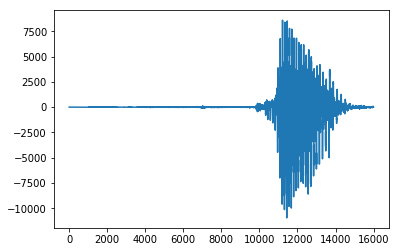

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x_tree[500])
import IPython.display as ipd
ipd.Audio(x_tree[500], rate=16000)

In [62]:
def diffLeftRight(wav):
    l = np.mean(np.abs(wav[0:8000]))
    r = np.mean(np.abs(wav[8001:]))
    return r - l

diffLeftRight(x_silence[1000])
diff_silence = []
diff_tree = []

for x in x_silence:
    diff_silence = diff_silence + [diffLeftRight(x)]
for x in x_tree:
    diff_tree = diff_tree + [diffLeftRight(x)]    



In [63]:
np.mean(diff_silence)

0.15630801

In [64]:
np.mean(diff_tree)

318.95087

In [65]:
np.median(diff_tree)

276.87646

In [29]:
def test_data_generator(batch=2):
    fpaths = glob('/content/datalab/docs/yaafe/test/audio/*.wav')
    i = 0
    for path in fpaths:
        if i == 0:
            imgs = []
            fnames = []
        i += 1
        print(path)
        rate, samples = wavfile.read(path)
        samples = pad_audio(samples)
        filter_banks = logfbank(samples)
        filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
        imgs.append(filter_banks)
        fnames.append(path.split('/')[-1])
        if i == batch:
            i = 0
            imgs = np.array(imgs)
            yield fnames, imgs
    if i < batch:
        imgs = np.array(imgs)

        yield fnames, imgs
    raise StopIteration()

index = []
results = []
probs = []
for fnames, imgs in test_data_generator(batch=32):
    predicts = model.predict(imgs)
    probs.extend(predicts)
    predicts = np.argmax(predicts, axis=1)
    predicts = [label_index[p] for p in predicts]
    index.extend(fnames)
    results.extend(predicts)

/content/datalab/docs/yaafe/test/audio/clip_006bd0d1c.wav
/content/datalab/docs/yaafe/test/audio/clip_48a85866b.wav


ValueError: File format b''... not understood.

In [24]:
wavfile.read('/content/datalab/docs/yaafe/test/audio/clip_48a85866b.wav', )

ValueError: File format b''... not understood.

In [21]:
wavfile.read?

In [ ]:
!more /content/datalab/docs/yaafe/test/audio/clip_006bd0d1c.wav